# オートエンコーダー（一般画像）
* MNISTではなく、アニメ顔とかのオートエンコーダーを作ってみる
* 白黒だけど
* 中間層にKL正規化項を入れ、変分AEにしている

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd
from PIL import Image
from StringIO import StringIO
import math

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence

import six

import matplotlib.pyplot as plt

# chainer exampleに付属のdata.pyをimportする. mnistのダウンロードのため
import data

## GPU設定

In [2]:
gpu_flag = 1
if gpu_flag >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_flag >= 0 else np

## データのロード

In [3]:
# img_size
size = 96
# image path
image_dir = "./images/anime_face"
# load images
fs = os.listdir(image_dir)
dataset = []
for fn in fs:
    f = open('%s/%s'%(image_dir,fn), 'rb')
    img_bin = f.read()
    img = np.asarray(Image.open(StringIO(img_bin)).convert('L')).astype(np.float32).reshape(size*size)
    dataset.append(img)
    f.close()
dataset = np.asarray(dataset)
print("num_of_images : %s"%dataset.shape[0])

## 画素が（-1~1）の範囲に収まるように調整する関数の定義
def clip_img(x):
    return np.float32(-1 if x<(-1) else (1 if x>1 else x))

num_of_images : 10000


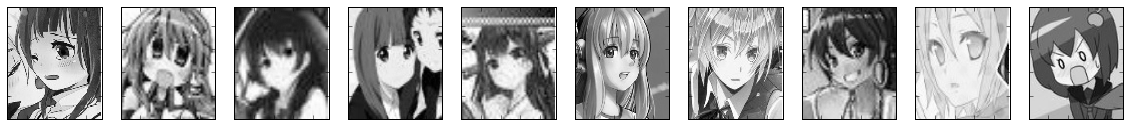

In [4]:
def draw_img_mc(data):
    size = 96
    n = data.shape[0]
    plt.figure(figsize=(n*2, 2))
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(1, n, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]             # flip vertical
        plt.xlim(0,size)
        plt.ylim(0,size)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
draw_img_mc( dataset[np.random.permutation( dataset.shape[0] )[:10]] )

In [5]:
N = dataset.shape[0]
train_rate = 0.7
N_train = int(N*train_rate)
N_test = N - N_train
print('N_dataset={}, N_train={}, N_test={}'.format(N, N_train, N_test))

# 正規化(0~1に)
dataset /= 255
# 訓練データとテストデータに分割
x_train, x_test = np.split(dataset,   [N_train])
print x_train.shape

N_dataset=10000, N_train=7000, N_test=3000
(7000, 9216)


## 学習パラメータの設定

In [7]:
batchsize = 100 # ミニバッチのサイズ
n_epoch = 50     # epoch数
n_latent = 1000   # 潜在変数の次元(DCGANで言うところのプライヤーベクトルの次元)
n_h = 5000   # 隠れ層のサイズ
beta = 10.0   # KL正則化項の重み

# Optimizer(Adam)
al = 0.001
b1 = 0.9
b2 = 0.999

## モデルの定義

In [8]:
class VAE(chainer.Chain):
    """AutoEncoder"""
    def __init__(self, n_in, n_latent, n_h):
        super(VAE, self).__init__(
            ## ネットワーク構造の定義
            # encoder
            le1=L.Linear(n_in, n_h),
            le2_mu=L.Linear(n_h, n_latent),
            le2_ln_var=L.Linear(n_h, n_latent),
            bne1=L.BatchNormalization(n_h), 
            # decoder
            ld1=L.Linear(n_latent, n_h),
            ld2=L.Linear(n_h, n_in),
            bnd1=L.BatchNormalization(n_h), 
        )

    def __call__(self, x, sigmoid=True):
        """AutoEncoder"""
        # 下記、encodeとdecodeの中身をこの中に書いても良いがencodeとｄｅｃｏｄｅは他でも使うので再利用性を高めるために
        return self.decode(self.encode(x)[0], sigmoid)

    def encode(self, x):
        # 推論モデル, 中間表現のベクトルqを学習
        h1 = F.relu(self.bne1(self.le1(x)))
        mu = self.le2_mu(h1)
        ln_var = self.le2_ln_var(h1)  # log(sigma**2)
        return mu, ln_var

    def decode(self, z, sigmoid=True):
        # 中間表現ベクトルqを入力として(z), 画像を生成
        h1 = F.relu(self.bnd1(self.ld1(z)))
        h2 = self.ld2(h1)
        if sigmoid:
            return F.sigmoid(h2)
        else:
            return h2

    def get_loss_func(self, C=1.0, k=1, train=True):
        """Get loss function of VAE.
        Args:
            C (int): Usually this is 1.0. Can be changed to control the
                second term of ELBO bound, which works as regularization.
            k (int): Number of Monte Carlo samples used in encoded vector.
            train (bool): If true loss_function is used for training.
        """
        def lf(x):
            mu, ln_var = self.encode(x)
            batchsize = len(mu.data)
            # reconstruction loss
            rec_loss = 0
            for l in six.moves.range(k):
                z = F.gaussian(mu, ln_var)
                rec_loss += F.bernoulli_nll(x, self.decode(z, sigmoid=False)) / (k * batchsize)
            self.rec_loss = rec_loss
            self.loss = self.rec_loss + C * gaussian_kl_divergence(mu, ln_var) / batchsize
            return self.loss
        return lf

## Optimizerの設定

In [9]:
# モデルの設定
model = VAE(size*size, n_latent, n_h) # VAE(n_in, n_latent, n_h) 
if gpu_flag >= 0:
    cuda.get_device(gpu_flag).use()
    model.to_gpu()
xp = np if gpu_flag < 0 else cuda.cupy

# Optimizerを定義する
optimizer = optimizers.Adam(alpha=al, beta1=b1, beta2=b2)
optimizer.setup(model)

## 訓練の実行

In [10]:
loss_arr = []
for epoch in six.moves.range(1, n_epoch + 1):
    print('epoch', epoch)
    
    # training
    ## 訓練データのsampler
    perm = np.random.permutation(N_train)
    ## lossのbuffer
    sum_loss = 0       # total loss
    sum_rec_loss = 0   # reconstruction loss
    ## バッチ学習
    for i in six.moves.range(0, N_train, batchsize):
        x = chainer.Variable(xp.asarray(x_train[perm[i:i + batchsize]])) # バッチ分のデータの抽出
        
        model.zerograds()
        loss = model.get_loss_func(C=beta)(x)
        loss.backward()
        optimizer.update()
        
        sum_loss += float(model.loss.data) * len(x.data)

    print('train mean loss={}'.format(sum_loss / N_train))
    loss_arr.append(float(sum_loss)/N_train)

('epoch', 1)
train mean loss=7555.83586775
('epoch', 2)
train mean loss=5779.48380301
('epoch', 3)
train mean loss=5806.91714565
('epoch', 4)
train mean loss=5737.2429827
('epoch', 5)
train mean loss=5769.30387835
('epoch', 6)
train mean loss=5720.22978516
('epoch', 7)
train mean loss=5676.38512137
('epoch', 8)
train mean loss=5649.40251116
('epoch', 9)
train mean loss=5634.37169364
('epoch', 10)
train mean loss=5603.81990792
('epoch', 11)
train mean loss=5587.30192522
('epoch', 12)
train mean loss=5570.1308245
('epoch', 13)
train mean loss=5563.63705357
('epoch', 14)
train mean loss=5546.75384347
('epoch', 15)
train mean loss=5532.53876256
('epoch', 16)
train mean loss=5528.81386719
('epoch', 17)
train mean loss=5521.10524554
('epoch', 18)
train mean loss=5526.25634068
('epoch', 19)
train mean loss=5514.30702427
('epoch', 20)
train mean loss=5509.09524275
('epoch', 21)
train mean loss=5500.13336356
('epoch', 22)
train mean loss=5500.3504534
('epoch', 23)
train mean loss=5490.13447963


## 結果の可視化

[]

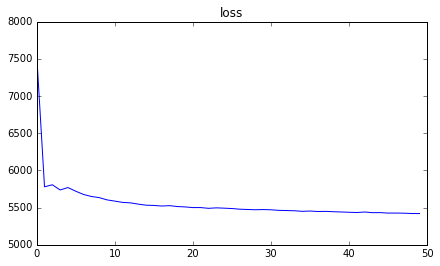

In [11]:
## lossグラフ
plt.figure(figsize=(7,4))
plt.plot(range(len(loss_arr)), loss_arr, color="#0000FF")
plt.title("loss")
plt.plot()

[6610 3985 6935 4001  802 1654 2639 2116 2477 3520]
input image


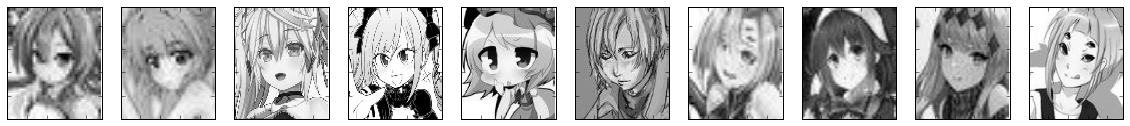

reconstruction image


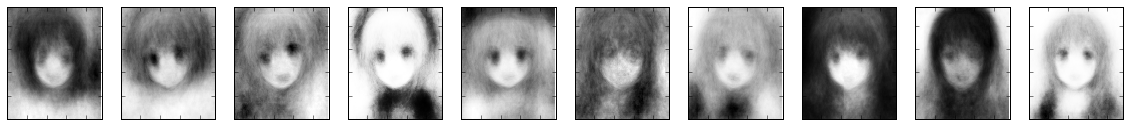

In [12]:
## 描画テスト (Closed test)
test_ind = np.random.permutation(N_train)[:10]
print test_ind
test = chainer.Variable(xp.asarray(x_train[test_ind]), volatile='on')
y = model(test)

print "input image"
draw_img_mc(x_train[test_ind])

print "reconstruction image"
draw_img_mc(y.data.get())


[1373 2330 2781 2622 2853 1869  488 2174 1257 1029]
input image


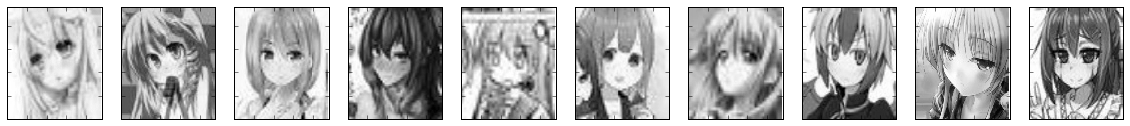

reconstruction image


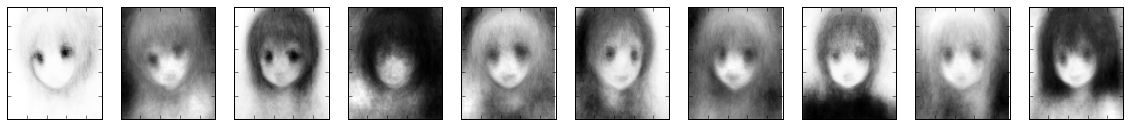

In [13]:
## 描画テスト (Open test) 
test_ind = np.random.permutation(N_test)[:10]
print test_ind
test = chainer.Variable(xp.asarray(x_test[test_ind]), volatile='on')
y = model(test)

print "input image"
draw_img_mc(x_test[test_ind])

print "reconstruction image"
draw_img_mc(y.data.get())

decode image from random vector


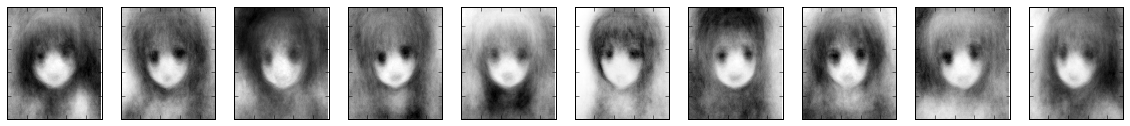

In [14]:
# draw images from randomly sampled z
z = chainer.Variable(xp.random.normal(0, 1, (10, n_latent)).astype(np.float32))
x = model.decode(z)
print "decode image from random vector"
draw_img_mc(x.data.get())

## 中間層の状態の確認

In [15]:
# 中間層の状態をプロットする
def draw_weight(data, size=96, N=100):
    # サンプラー
    n = N
    n_col = int(math.ceil(N / 10))
    indexes = np.random.permutation( len(data) )[:n]
    size = size
    plt.figure(figsize=(10*2, n_col*2))
    # plot
    cnt = 1
    for idx in indexes:
        plt.subplot(n_col, 10, cnt)
        X, Y = np.meshgrid(range(size),range(size))
        Z = data[idx].reshape(size,size)   # convert from vector to 28x28 matrix
        Z = Z[::-1,:]
        plt.xlim(0, size-1)
        plt.ylim(0, size-1)
        plt.pcolor(X, Y, Z)
        plt.gray()
        plt.title("{0}".format(idx), size=9)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
    return indexes

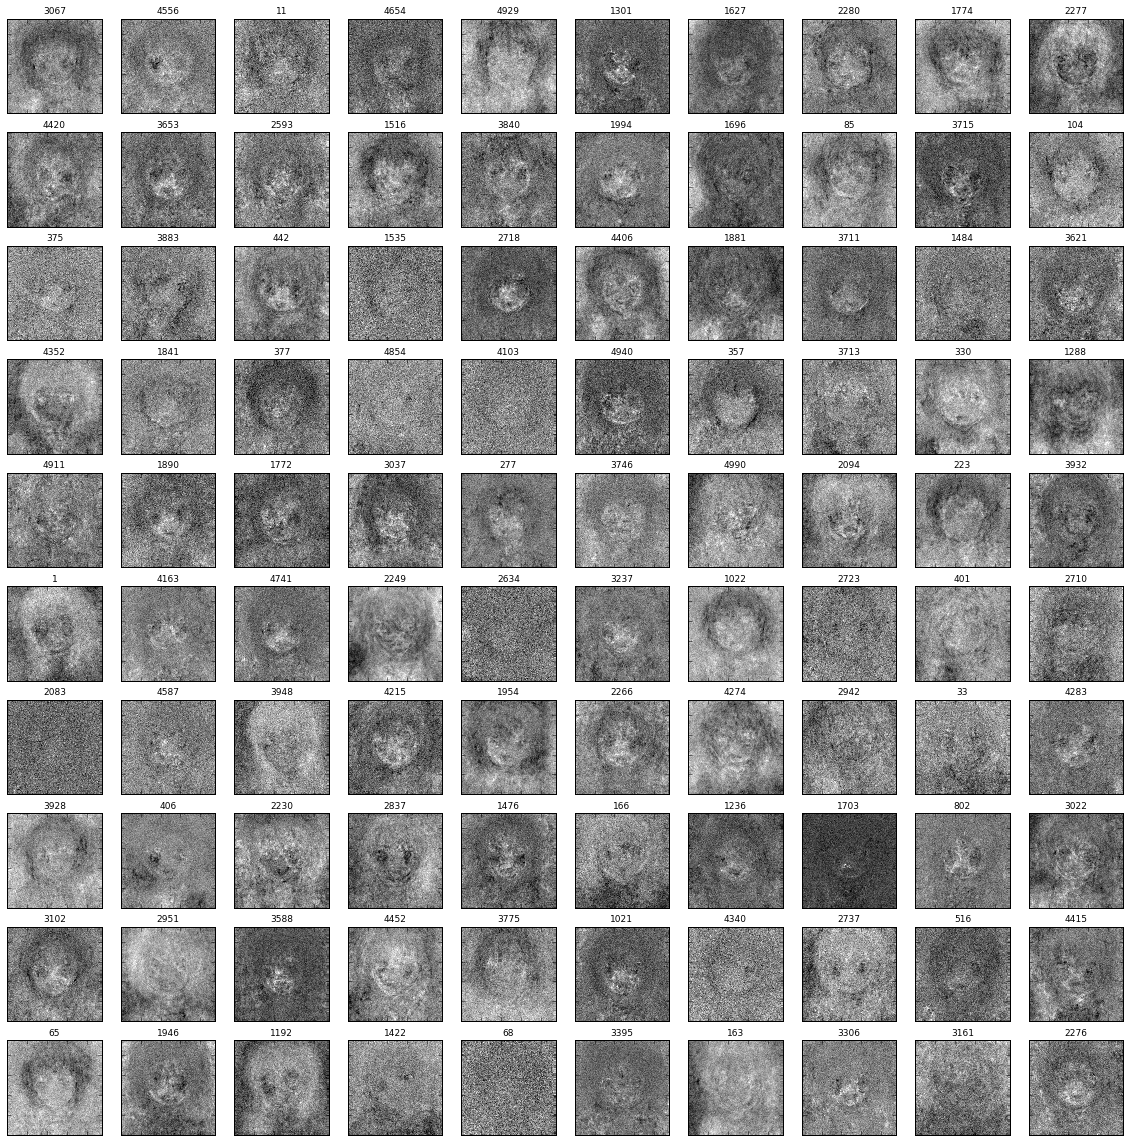

In [16]:
# 入力層の次の中間層
idxs = draw_weight(model.le1.W.data.get(), N=100)

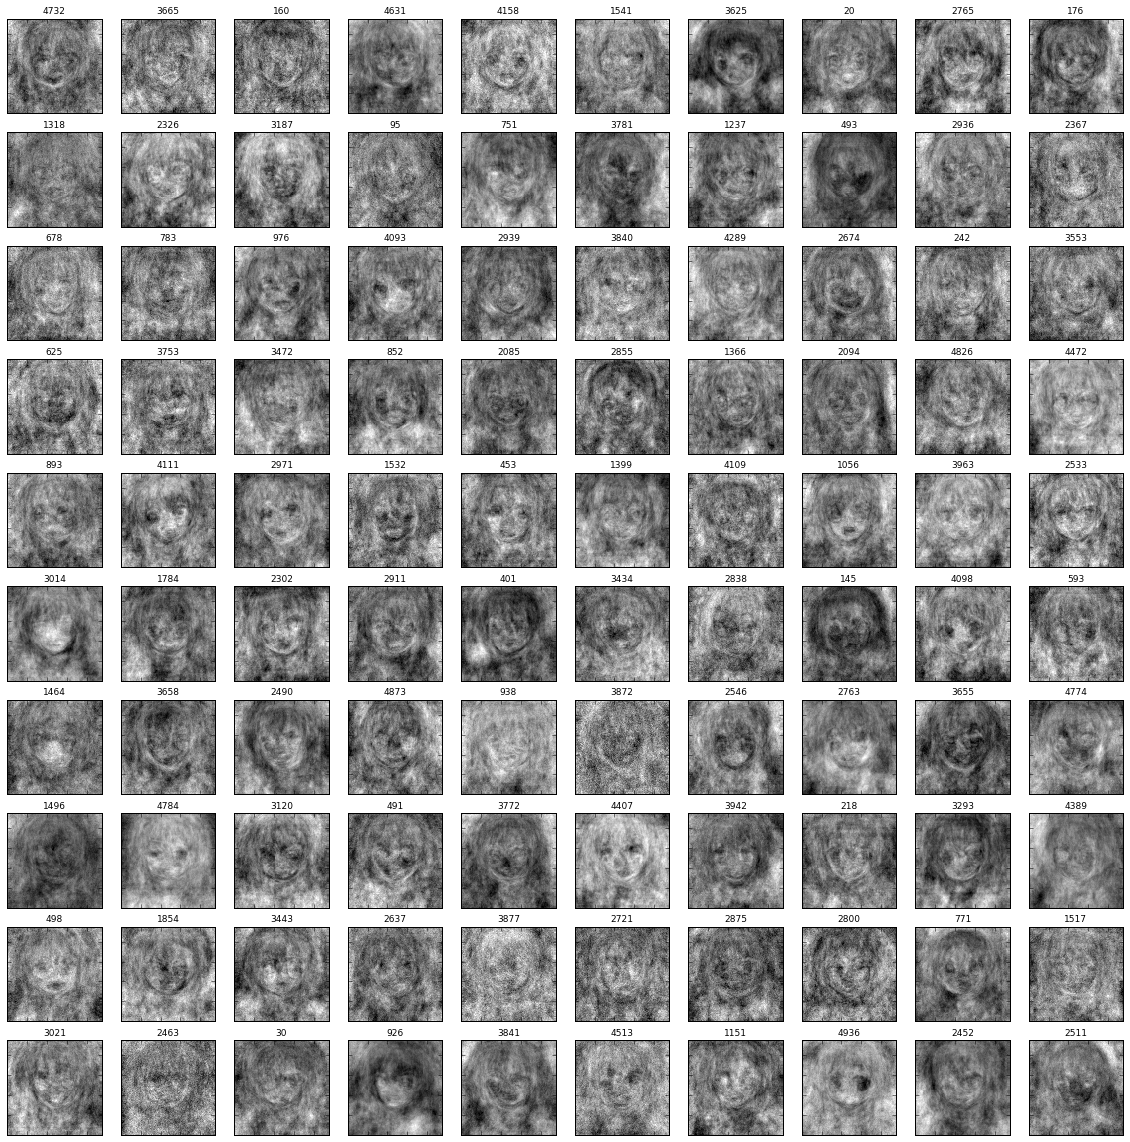

In [17]:
# 出力層の手前
idx = draw_weight(model.ld2.W.data.get().T, N=100)